In [3]:
# !pip install camb

In [ ]:
import numpy as np
import camb
from camb import model, initialpower
import matplotlib.pyplot as plt

# The prior : $p(\theta)$

In [ ]:
# Step 1: Define Prior Sampling
def sample_theta(n_samples):
    H0_samples = np.random.uniform(50, 90, n_samples)          # Hubble constant
    Omega_m_samples = np.random.uniform(0.2, 0.4, n_samples)   # Matter density
    n_s_samples = np.random.uniform(0.9, 1.1, n_samples)        # Spectral index
    return np.stack([H0_samples, Omega_m_samples, n_s_samples], axis=1)

In [12]:
import platform

print("Processor:", platform.processor())


Processor: Intel64 Family 6 Model 140 Stepping 1, GenuineIntel


In [7]:
!cat /proc/cpuinfo | grep "model name" | head -1

model name	: 11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz


In [9]:
!uname -a    # general OS info

uname: extra operand '#'
Try 'uname --help' for more information.


In [10]:
import platform
import multiprocessing

print("CPU:", platform.processor())
print("Cores:", multiprocessing.cpu_count())


CPU: Intel64 Family 6 Model 140 Stepping 1, GenuineIntel
Cores: 8


In [ ]:
# Step 2: Generate P(k) using CAMB
def generate_pk(theta, k_min=1e-4, k_max=1.0, n_k=100):
    H0, Omega_m, n_s = theta
    pars = camb.CAMBparams()

    Omega_b = 0.05                     # fixed baryon density
    Omega_c = Omega_m - Omega_b       # cold dark matter from total matter

    pars.set_cosmology(H0=H0, ombh2=Omega_b * (H0 / 100)**2, omch2=Omega_c * (H0 / 100)**2)
    pars.InitPower.set_params(ns=n_s)
    pars.set_matter_power(redshifts=[0.], kmax=k_max)
    
    results = camb.get_results(pars)
    k = np.logspace(np.log10(k_min), np.log10(k_max), n_k)
    PK = results.get_matter_power_spectrum(minkh=k_min, maxkh=k_max, npoints = n_k)[0]
    return k, PK

In [ ]:
# Step 3: Add Gaussian noise
def add_noise(pk, noise_std=0.05):
    noise = np.random.normal(0, noise_std * np.abs(pk))
    return pk + noise

In [ ]:

# Step 4: Create Dataset
def generate_dataset(n_samples=1000, noise_std=0.05):
    theta_all = sample_theta(n_samples)
    dataset = []
    for theta in theta_all:
        try:
            k_vals, pk_clean = generate_pk(theta)
            pk_noisy = add_noise(pk_clean, noise_std)
            dataset.append((pk_noisy, theta))
        except Exception as e:
            print(f"Error at theta={theta}: {e}")
    return k_vals, dataset

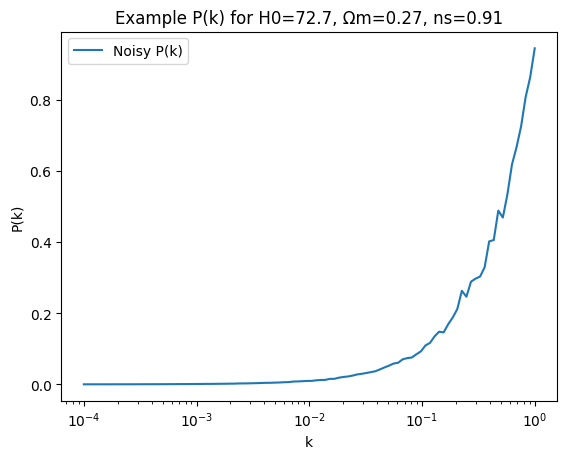

In [13]:
# ✅ Example usage
if __name__ == "__main__":
    k, dataset = generate_dataset(n_samples=500, noise_std=0.05)
    
    # Plot example
    import random
    pk_sample, theta_sample = random.choice(dataset)
    plt.plot(k, pk_sample, label='Noisy P(k)')
    plt.xscale('log')
    plt.xlabel('k')
    plt.ylabel('P(k)')
    plt.title(f"Example P(k) for H0={theta_sample[0]:.1f}, Ωm={theta_sample[1]:.2f}, ns={theta_sample[2]:.2f}")
    plt.legend()
    plt.show()
